In [1]:
using CSV
using DataFrames
using Plots
using Statistics 
using StatsPlots
using Random

In [2]:
"""
Project Goal: 

1) Predict the probability that a horse wins in a given race
2) Predict what the final win dividends will be for a horse in a given race

Then, use our predictions to maximize the expected value of betting on races to earn a profit

"""

"Project Goal: \n\n1) Predict the probability that a horse wins in a given race\n2) Predict what the final win dividends will be for a horse in a given race\n\nThen, use our predictions to maximize the expected value of betting on races to earn a profit\n\n"

# Exploratory Data Analysis

In [3]:
# Load in our data

races = CSV.read("races.csv")
runs = CSV.read("runs.csv")

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country
,Int64,Int64,Int64,Int64,Float64,Float64,Int64,String?
1,0,1,3917,10,0.0,8.0,3,AUS
2,0,2,2157,8,0.0,5.75,3,NZ
3,0,3,858,7,0.0,4.75,3,NZ
4,0,4,1853,9,0.0,6.25,3,SAF
5,0,5,2796,6,0.0,3.75,3,GB
6,0,6,3296,3,0.0,1.25,3,NZ
7,0,7,911,12,0.0,9.5,3,NZ
8,0,8,2170,1,1.0,0.0,3,AUS
9,0,9,1730,13,0.0,9.75,3,NZ


In [4]:
print(size(runs), size(races))

(79447, 37)(6349, 37)

In [5]:
function summary_stats(arr)
    clean_arr = skipmissing(arr)
    print("missing: $(mean(ismissing.(arr)))%\n")
    print("maximum: $(maximum(clean_arr))\n")
    print("minimum: $(minimum(clean_arr))\n")
    print("median:  $(median(clean_arr))\n")
    print("mean:    $(mean(clean_arr))\n")
    print("std:     $(std(clean_arr))\n")
end

summary_stats (generic function with 1 method)

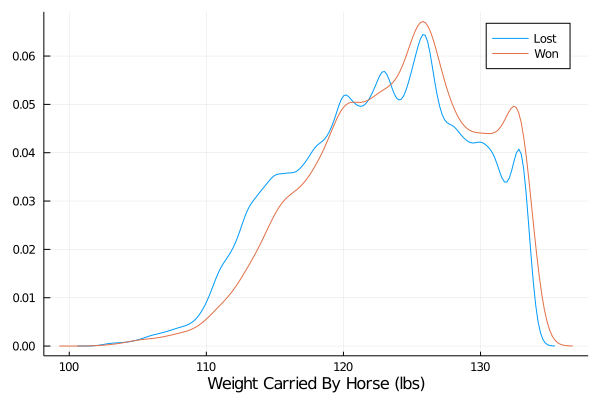

In [6]:
density(runs[:actual_weight], group=runs[:won], labels= ["Lost" "Won"])
xlabel!("Weight Carried By Horse (lbs)")

In [7]:
temp_hist = by(runs, :horse_type, nrow )
temp_hist

,horse_type,nrow
,String?,Int64
1,Gelding,75503
2,Mare,238
3,Horse,1093
4,Brown,2044
5,Rig,154
6,Colt,305
7,missing,2
8,Roan,48
9,Filly,43


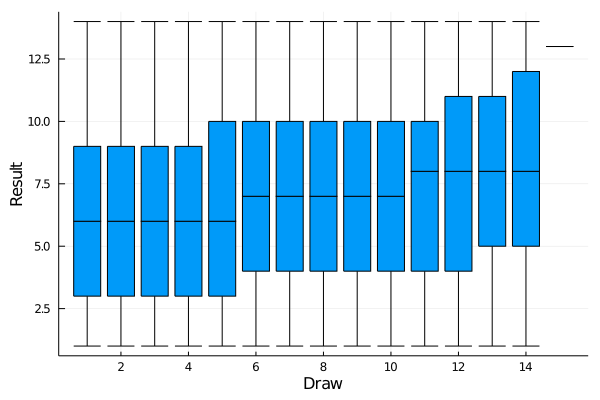

In [8]:
boxplot(runs[:draw], runs[:result], label="")
xlabel!("Draw")
ylabel!("Result")

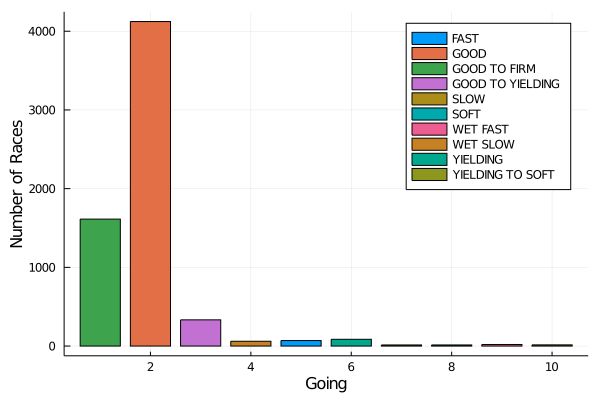

In [9]:
temp_hist = by(races, :going, nrow )
dropmissing!(temp_hist)
bar(temp_hist[:nrow], group=temp_hist[:going])
xlabel!("Going")
ylabel!("Number of Races")

# Preprocessing Data

In [10]:
# Inner join races and runs to get full dataset 
select!(races, Not(:time1))
select!(races, Not(:time2))
select!(races, Not(:time3))
select!(races, Not(:time4))
select!(races, Not(:time5))
select!(races, Not(:time6))
select!(races, Not(:time7))

full_data = innerjoin(races, runs, on =:race_id)

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings
,Int64,Date…,String,Int64,String,Int64,Int64,String,String
1,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
2,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
3,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
4,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
5,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
6,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
7,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
8,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
9,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15


In [11]:
# Getting the column names in our dataset that have at least one missing entry 

cols_missing = colwise(x -> any(ismissing.(x)), full_data)
cols_with_missing = []
for i=1:66
    if cols_missing[i] > 0 
        append!(cols_with_missing, i)
    end
end

names_list = names(full_data)
col_names_missing =[]
for i in cols_with_missing
    push!(col_names_missing, String(names_list[i]))
end

print(x for x in col_names_missing)

Base.Generator{Array{Any,1},typeof(identity)}(identity, Any["prize", "sec_time4", "sec_time5", "sec_time6", "sec_time7", "place_combination3", "place_combination4", "place_dividend3", "place_dividend4", "win_combination2", "win_dividend2", "horse_country", "horse_type", "position_sec4", "position_sec5", "position_sec6", "behind_sec4", "behind_sec5", "behind_sec6", "time4", "time5", "time6", "place_odds"])

In [12]:
# Now we need to address these missing values 
# Lets look out percent of missing in each column.

for name in col_names_missing 
    try
        print(name)
        print("\n")
        summary_stats(full_data[name])
        print("\n")
    catch
        print("***************************")
        print("Empty array")
        print("***************************\n")
    end
    
end

prize
missing: 0.07362140798268028%
maximum: 2.5e7
minimum: 485000.0
median:  800000.0
mean:    1.117460528818718e6
std:     1.7347670152607828e6

sec_time4
missing: 0.4181529824914723%
maximum: 28.92
minimum: 21.4
median:  23.76
mean:    23.841666161899663
std:     0.801872692835738

sec_time5
missing: 0.8731355494858207%
maximum: 26.5
minimum: 21.81
median:  23.83
mean:    23.87469887885699
std:     0.7450271642038292

sec_time6
missing: 0.9836872380329025%
maximum: 25.92
minimum: 21.77
median:  24.03
mean:    23.934236111111105
std:     0.6605929498312835

sec_time7
missing: 1.0%
***************************Empty array***************************
place_combination3
missing: 0.001762181076692638%
maximum: 14.0
minimum: 1.0
median:  6.0
mean:    6.583983759315067
std:     3.7615102585466706

place_combination4
missing: 0.9963371807620175%
maximum: 14.0
minimum: 4.0
median:  8.0
mean:    8.391752577319588
std:     2.914494222511631

place_dividend3
missing: 0.001762181076692638%
maximum:

In [13]:
"""
We are removing the following columns from the dataset:

    horse_id
    horse_gear
    race_id

    sec_time1
    sec_time2
    sec_time3
    sec_time4
    sec_time5
    sec_time6
    sec_time7

    time1
    time2
    time3
    time4
    time5
    time6
    
    place_combination1 
    place_combination2
    place_combination3
    place_combination4 

    place_dividend1
    place_dividend2
    place_dividend3
    place_dividend4 

    win_combination1
    win_combination2 
    
    win_dividend2

    place_odds

    position_sec1
    position_sec2
    position_sec3
    position_sec4
    position_sec5
    position_sec6
    
    behind_sec1
    behind_sec2
    behind_sec3
    behind_sec4
    behind_sec5
    behind_sec6

    result
    lengths_behind
    finish_time
    win_odds
"""

select!(full_data, Not(:horse_id))
select!(full_data, Not(:horse_gear))
select!(full_data, Not(:race_id))

select!(full_data, Not(:sec_time1))
select!(full_data, Not(:sec_time2))
select!(full_data, Not(:sec_time3))
select!(full_data, Not(:sec_time4))
select!(full_data, Not(:sec_time5))
select!(full_data, Not(:sec_time6))
select!(full_data, Not(:sec_time7))

select!(full_data, Not(:time1))
select!(full_data, Not(:time2))
select!(full_data, Not(:time3))
select!(full_data, Not(:time4))
select!(full_data, Not(:time5))
select!(full_data, Not(:time6))
                            
select!(full_data, Not(:place_combination1))
select!(full_data, Not(:place_combination2))
select!(full_data, Not(:place_combination3))
select!(full_data, Not(:place_combination4))

select!(full_data, Not(:place_dividend1))
select!(full_data, Not(:place_dividend2))
select!(full_data, Not(:place_dividend3))
select!(full_data, Not(:place_dividend4))

select!(full_data, Not(:win_combination1))   
select!(full_data, Not(:win_combination2))

select!(full_data, Not(:win_dividend2))

select!(full_data, Not(:place_odds))

select!(full_data, Not(:position_sec1))
select!(full_data, Not(:position_sec2))
select!(full_data, Not(:position_sec3))
select!(full_data, Not(:position_sec4))
select!(full_data, Not(:position_sec5))
select!(full_data, Not(:position_sec6))

select!(full_data, Not(:behind_sec1))
select!(full_data, Not(:behind_sec2))
select!(full_data, Not(:behind_sec3))
select!(full_data, Not(:behind_sec4))
select!(full_data, Not(:behind_sec5))
select!(full_data, Not(:behind_sec6))


select!(full_data, Not(:result))
select!(full_data, Not(:lengths_behind))
select!(full_data, Not(:finish_time))
select!(full_data, Not(:win_odds))

,date,venue,race_no,config,surface,distance,going,horse_ratings
,Date…,String,Int64,String,Int64,Int64,String,String
1,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
2,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
3,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
4,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
5,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
6,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
7,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
8,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
9,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15


In [14]:
"""
We are replacing missing values with the column mean for the following columns:
    prize


Deleting the missing rows from these columns: 
    place_dividend3 -> since there are only a handful missing (0.1% missing)
    
    horse_country -> missing extremely few (0.000025%) missing -> 2 rows! 

    horse_type -> same two rows missing as horse_country that will be deleted 

"""

# rip on julia here cause we found a bug 
temp_prize = DataFrame(hcat(full_data[:prize], full_data[:horse_type]))
dropmissing!(temp_prize, :x1)
temp_mean = mean(temp_prize[:x1])

full_data.prize = coalesce.(full_data.prize, temp_mean)


# dropping  missing values from place_dividend3 only a handful of rows
# dropmissing!(full_data, :place_dividend3)
dropmissing!(full_data, :horse_country)

dropmissing!(full_data, :horse_type)



# *****************************
# Huge bug 
# *************************
# replacing missing values with the column mean for prize

#coalesce.(full_data, mean(full_data[:prize]))
# select!(full_data, Not(:prize))
# full_data = hcat(full_data, prize_temp)

,date,venue,race_no,config,surface,distance,going,horse_ratings
,Date…,String,Int64,String,Int64,Int64,String,String
1,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
2,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
3,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
4,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
5,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
6,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
7,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
8,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15
9,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15


In [15]:
"""
For our date column we will convert the Date object to a day of the year (int) to account for seasonality.
"""

using Dates
N = 79445
dayofyear = []
for i=1:N
    append!(dayofyear, Dates.dayofyear(full_data[i, :date]))
end

full_data = hcat(dayofyear, full_data)
select!(full_data, Not(:date))

,x1,venue,race_no,config,surface,distance,going,horse_ratings,prize
,Any,String,Int64,String,Int64,Int64,String,String,Float64
1,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
2,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
3,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
4,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
5,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
6,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
7,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
8,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0
9,153,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0


# Feature Engineering

In [16]:
"""
For categorical features we will be doing one-hot encoding over many hot encoding because we do not have any sets.

"""
one_hot_labels = [
  :horse_type,
  :horse_country,
  :config,
  :venue,
  :going, 
  :horse_ratings,
  :jockey_id,
  :trainer_id
]

#Sets of all categories in a particular column
uniq_sets = [unique(full_data[:, label]) for label in one_hot_labels]


"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    result = zeros(length(column), length(cats))
 
    for r in 1:length(column)
        for c in 1:length(cats)
            
            if column[r] == cats[c] 
                result[r, c] = 1
            
            end
        end
    end
   
    result
end


onehot

In [17]:
htype = onehot(full_data[:, :horse_type], uniq_sets[1])
hcountry = onehot(full_data[:, :horse_country], uniq_sets[2])
config = onehot(full_data[:, :config], uniq_sets[3])
venue = onehot(full_data[:, :venue], uniq_sets[4])
going = onehot(full_data[:, :going], uniq_sets[5])
horse_ratings = onehot(full_data[:, :horse_ratings], uniq_sets[6])
jockey_id = onehot(full_data[:, :jockey_id], uniq_sets[7])
trainer_id = onehot(full_data[:, :trainer_id], uniq_sets[8])

one_hots = hcat(htype, hcountry, config, venue, going, horse_ratings, jockey_id, trainer_id)

79445×436 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [18]:
select!(full_data, Not(:horse_type))
select!(full_data, Not(:horse_country))
select!(full_data, Not(:venue))
select!(full_data, Not(:config))
select!(full_data, Not(:going))
select!(full_data, Not(:horse_ratings))
select!(full_data, Not(:jockey_id))
select!(full_data, Not(:trainer_id))

,x1,race_no,surface,distance,prize,race_class,win_dividend1,horse_no
,Any,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,121.0,1
2,153,1,0,1400,485000.0,5,121.0,2
3,153,1,0,1400,485000.0,5,121.0,3
4,153,1,0,1400,485000.0,5,121.0,4
5,153,1,0,1400,485000.0,5,121.0,5
6,153,1,0,1400,485000.0,5,121.0,6
7,153,1,0,1400,485000.0,5,121.0,7
8,153,1,0,1400,485000.0,5,121.0,8
9,153,1,0,1400,485000.0,5,121.0,9


In [19]:
final_full_data = hcat(full_data, DataFrame(one_hots), makeunique=true)

,x1,race_no,surface,distance,prize,race_class,win_dividend1,horse_no
,Any,Int64,Int64,Int64,Float64,Int64,Float64,Int64
1,153,1,0,1400,485000.0,5,121.0,1
2,153,1,0,1400,485000.0,5,121.0,2
3,153,1,0,1400,485000.0,5,121.0,3
4,153,1,0,1400,485000.0,5,121.0,4
5,153,1,0,1400,485000.0,5,121.0,5
6,153,1,0,1400,485000.0,5,121.0,6
7,153,1,0,1400,485000.0,5,121.0,7
8,153,1,0,1400,485000.0,5,121.0,8
9,153,1,0,1400,485000.0,5,121.0,9


In [20]:
summary_stats(full_data[:prize])

missing: 0.0%
maximum: 2.5e7
minimum: 485000.0
median:  850000.0
mean:    1.1174729263397404e6
std:     1.6697066808360922e6


# Least Squares Regression Model

In [21]:

"""
Now we will begin fitting models to our dataset.

Because of the nature of our problem, we will have 2 separate models, per distance dataset, one predicting the win_dividends 
and one predicting and one result.


We start by isolating our y vector and splitting our dataset into train and test sets.
"""

# starting with the 1000 distance 
# First model predicting result


# Shuffling the dataset out of order 
final_full_data = final_full_data[shuffle(1:end), :]

train_proportion = 0.8
n = size(final_full_data, 1)


println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))


target = final_full_data[:win_dividend1]
select!(final_full_data, Not(:won))
X = convert(Matrix, select!(final_full_data, Not(:win_dividend1)))
for i=1:89
     X[:, i] = [convert(Float64, X[k, i]) for k=1:79445]
end
X = convert(Array{Float64}, X)

train_x = X[1:ntrain, :]
test_x = X[ntrain+1:end, :]
train_y = target[1:ntrain, :]
test_y = target[ntrain+1:end, :]


train_x = hcat(train_x, ones(ntrain))
test_x = hcat(test_x, ones(n-ntrain))

train_y = [convert(Float64, train_y[i]) for i=1:size(train_y,1)]
test_y = [convert(Float64, test_y[i]) for i=1:size(test_y,1)]

Size of dataset: 79445


15889-element Array{Float64,1}:
  46.0
  87.0
 140.0
 270.5
  31.5
 208.0
  47.0
  69.5
  43.5
 147.5
  44.5
  34.5
 117.0
   ⋮
  78.5
  42.0
  39.0
  81.5
  68.0
  37.5
 225.0
  42.0
 174.5
  91.0
  41.0
  91.0

In [22]:
summary_stats(full_data[:win_dividend1])

missing: 0.0%
maximum: 2687.5
minimum: 10.5
median:  59.0
mean:    97.11290200767827
std:     132.89133550084745


In [23]:
# Creating w
w = train_x\train_y

train_pred = train_x*w
test_pred = test_x*w


function MSE(y, pred)
    #finish function
    mse = []
    for (y, y_hat) in zip(y, pred)
        append!(mse, (y - y_hat)^2)
    end
    sum_mse = sum(mse)/length(mse)
end


train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	17260.627813905143
Test MSE 	18001.506198993884


In [ ]:
### Mean Absolute error 

In [32]:
function MAE(y, pred)
    #finish function
    mae = []
    for (y, y_hat) in zip(y, pred)
        append!(mae, abs(y - y_hat))
    end
    sum_mae = sum(mae)/length(mae)
end

train_MAE = MSE(train_y, train_pred)
test_MAE = MSE(test_y, test_pred)

println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)


Train MAE	70.40315435103801
Test MAE 	70.71244402149921


In [ ]:
### Random Forest 

In [56]:
import Pkg
Pkg.add("DecisionTree")

   Updating registry at `C:\Users\swastikgoatchaki\.julia\registries\General`
  Resolving package versions...
  Installed DecisionTree ─ v0.10.10
Updating `C:\Users\swastikgoatchaki\.julia\environments\v1.5\Project.toml`
  [7806a523] + DecisionTree v0.10.10
Updating `C:\Users\swastikgoatchaki\.julia\environments\v1.5\Manifest.toml`
  [7806a523] + DecisionTree v0.10.10


In [26]:
using DecisionTree

In [28]:
model = build_forest(train_y, train_x, 2, 10, 0.7, 5)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 20.8
Avg Depth:  5.0

In [29]:
prediction_model = apply_forest(model, test_y)

89.34611111111113

In [33]:
MSE(test_y, prediction_model)



43.34611111111113

In [34]:
MAE(test_y, prediction_model)

43.34611111111113

In [74]:
n_subfeatures=8; n_trees=10; partial_sampling=0.7; max_depth=-1
min_samples_leaf=5; min_samples_split=2; min_purity_increase=0.0; seed=3

model = build_forest(train_y, train_x,
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 7082.7
Avg Depth:  71.8

In [23]:
w_abs = abs.(w)

final_features = []
numbered_w = []

for i=1:length(w_abs)
    push!(numbered_w, (w_abs[i], i))
end

sort!(numbered_w, rev=true)
feature_selected_w = numbered_w[1:100]

# Getting final w, since we dont need tuples anymore
final_w = []
for i=1:length(feature_selected_w)
    push!(final_w, feature_selected_w[i][1])
end
final_w

feature_selected_X = Array{Float64}(undef, size(X)[1], length(feature_selected_w))
for i=1:length(feature_selected_w)
    feature_selected_X[:, i] = X[:, feature_selected_w[i][2]]
end

LoadError: BoundsError: attempt to access 79445×448 Array{Float64,2} at index [1:79445, 449]

In [24]:
# function to calculate win percentage of all horses in data that have a 
# win prediction value greater than or equal to a.

function win_prob(a, pred, data)
    prob = []
    for i=1:size(pred)[1]
        if (pred[i]>=a)
            append!(prob, data[i])
        end
    end
    try
        return sum(prob)/size(prob)[1]
    catch e
        return 0
    end 
end

win_prob (generic function with 1 method)

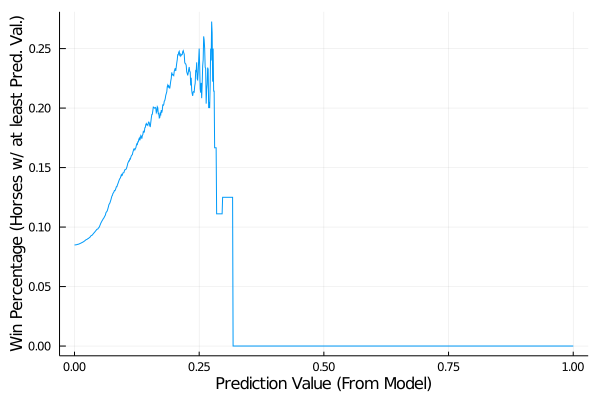

In [31]:
inc = [0:0.001:1;]

prob_plot_y = [win_prob(x, test_pred, test_y) for x in inc]

plot(inc, prob_plot_y, label="")
xlabel!("Prediction Value (From Model)")
ylabel!("Win Percentage (Horses w/ at least Pred. Val.)")

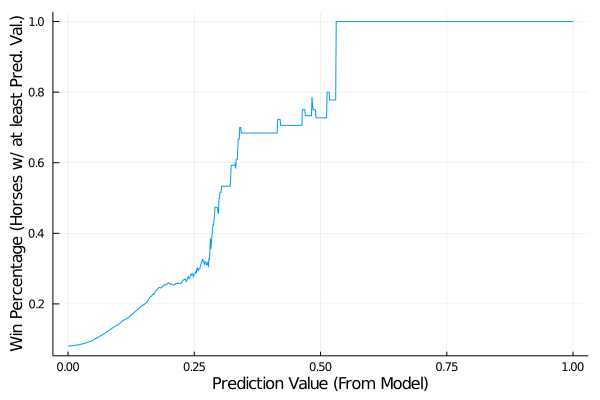

In [32]:
inc = [0:0.001:1;]

prob_plot_y = [win_prob(x, train_pred, train_y) for x in inc]

plot(inc, prob_plot_y, label="")
xlabel!("Prediction Value (From Model)")
ylabel!("Win Percentage (Horses w/ at least Pred. Val.)")

# Logistic Loss